В данном блокноте продемонстрируем некоторые методы сегментирования изображений.

Начнем с метода водораздела (Watershed Segmentation), а затем продемонстрируем применение глубоких нейросетевых архитектур к задаче сегментирования изображений.

Для начала установим необходимые бибилиотеки

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import colorsys
import argparse
import imutils
import random
import os
import sys
from google.colab.patches import cv2_imshow

Загружаем изображение и применяем pyramid mean shift filter — функцию в OpenCV, что уменьшает количество цветов. Далее переводим изображение в градации серого (метод водораздела работает с монохромной цветовой гаммой). 

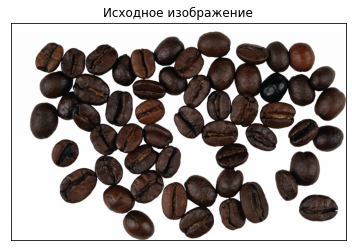

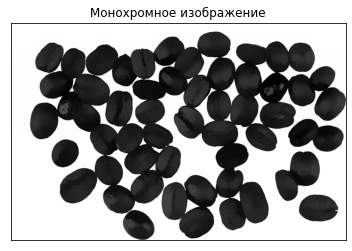

In [2]:
img = cv2.imread('/content/coffee.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.show()
shifted = cv2.pyrMeanShiftFiltering(img, 21, 51)
gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
plt.imshow(gray, 'gray')
plt.title('Монохромное изображение'), plt.xticks([]), plt.yticks([])
plt.show()

Для получения хорошего результата, необходимо проделать ряд манипуляций.

Применим метод Оцу, который использует гистограмму изображения для расчета порога отсечения, позволяющего разделить наше изображение на светлые и темные объекты.

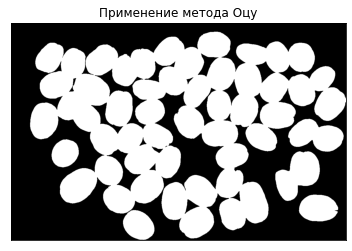

In [3]:
thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
plt.imshow(thresh, 'gray')
plt.title('Применение метода Оцу'), plt.xticks([]), plt.yticks([])
plt.show()

Проведем ряд простых морфологических операций: уберем шум

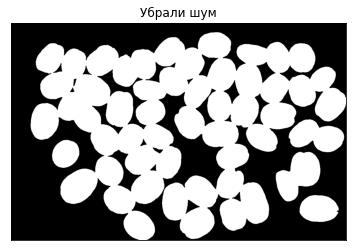

In [4]:
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE, np.ones((2,2),np.uint8), iterations = 2)
plt.imshow(closing, 'gray')
plt.title('Убрали шум'), plt.xticks([]), plt.yticks([])
plt.show()

Если разница двух последних результатов не заметна, увеличьте размер выводимых изображений.

Размоем фон с помощью функции dilate, а далее применим
Distance transform — значение каждого пикселя заменяется на его расстоянием до ближайшего пикселя фона. 

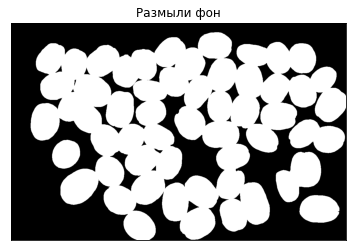

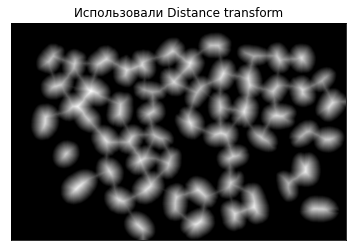

In [5]:
sure_bg = cv2.dilate(closing,np.ones((2,2),np.uint8),iterations=3)
plt.imshow(sure_bg, 'gray')
plt.title('Размыли фон'), plt.xticks([]), plt.yticks([])
plt.show()
dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
plt.imshow(dist_transform, 'gray')
plt.title('Использовали Distance transform'), plt.xticks([]), plt.yticks([])
plt.show()

Выполняем пороговое преобразование для получения пиков. Это будут маркеры для объектов переднего плана.

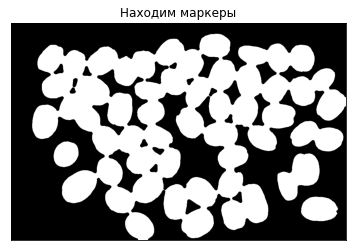

In [6]:
sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)[1]
sure_fg = np.uint8(sure_fg)
plt.imshow(sure_fg, 'gray')
plt.title("Находим маркеры"), plt.xticks([]), plt.yticks([])
plt.show()

На данный момент у нас есть пики и фон. Вычитая из размытого изображения пики, получаем область, которая не определена.

Области, в которых мы уверены, обозначаем разными положительными целыми числами, а неопределенную область обозначаем 0. Для этого используем функцию cv2.connectedComponents(). Эта функция присваивает фону значение 0, а нефоновым объектам присваивает целые значения, начиная с единицы.

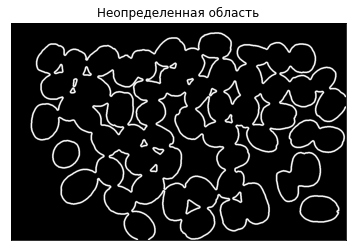

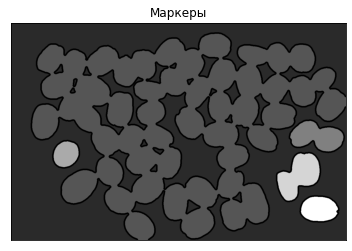

In [7]:
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown, 'gray')
plt.title("Неопределенная область"), plt.xticks([]), plt.yticks([])
plt.show()
markers = cv2.connectedComponents(sure_fg)[1]
markers = markers+1 # прибавляем 1, чтобы избежать 0 в областях, которые определены
markers[unknown==255] = 0
plt.imshow(markers, 'gray')
plt.title("Маркеры"), plt.xticks([]), plt.yticks([])
plt.show()

А теперь применим функцию водораздела, границам маркеров будет присвоено значение -1. На исходном изображении эти пиксели окрасим в синий цвет.

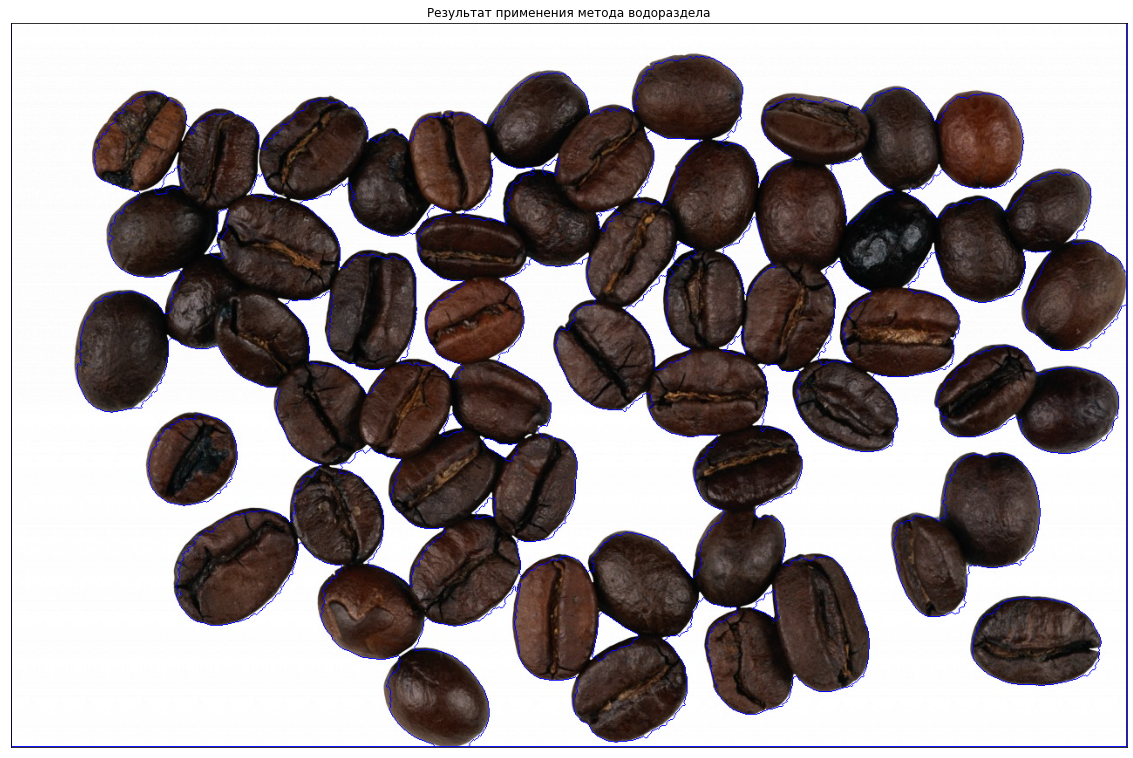

In [8]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [0,0,255]
fig = plt.figure(figsize=(20,20))
plt.imshow(img)
plt.title("Результат применения метода водораздела"), plt.xticks([]), plt.yticks([])
plt.show()


Теперь рассмотрим сегментирование изображений с помощью глубоких нейросетевых архитектур на примере Mask R-CNN.

Мы воспользуемся уже обученной моделью. Сначала надо доустановить требуемые библиотеки.

In [9]:
!pip install keras==2.3.0
%tensorflow_version 1.x

     |████████████████████████████████| 378kB 4.1MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
TensorFlow 1.x selected.


In [10]:
!pip install 'h5py<3.0.0'

     |████████████████████████████████| 2.9MB 3.9MB/s 
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


Клонируем репозиторий с исходниками.

In [11]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 33.02 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [12]:
!pip3 install mrcnn
!pip install  -r /content/Mask_RCNN/requirements.txt
!python /content/Mask_RCNN/setup.py install

     |████████████████████████████████| 61kB 2.2MB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-cp37-none-any.whl size=54930 sha256=108dfb5a6acd4eecab83d39fd43e042ef52861ca379214a83a92c7e8e8752a79
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn
     |████████████████████████████████| 163kB 2.9MB/s 
     |████████████████████████████████| 204kB 32.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=eb47aebce75ab55ffe8d7577536ef75cf35f89cfa4e5f8ee19b0d1a07f82ba61
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.2 which is incompatible.
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
running install
running bdist_egg
running egg_info
crea

In [13]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


Создаем конфигурацию, определяем поля

In [14]:
class MaskRCNNConfig(Config):
    NAME = "coco_pretrained_model_config"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.8 # минимальный процент отображения прямоугольника
    NUM_CLASSES = 81

Загружаем файл с весами

In [15]:
import mrcnn.utils
DATASET_FILE = "mask_rcnn_coco.h5"
if not os.path.exists(DATASET_FILE):
    mrcnn.utils.download_trained_weights(DATASET_FILE)

... done downloading pretrained model!


Создаем модель

In [16]:
model = modellib.MaskRCNN(mode="inference", model_dir=os.getcwd(), config=MaskRCNNConfig())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


Загружаем веса

In [17]:
model.load_weights(DATASET_FILE, by_name=True)

Из директории Mask_RCNN/images/ выбираем любой файл

/content/Mask_RCNN/images/12283150_12d37e6389_z.jpg


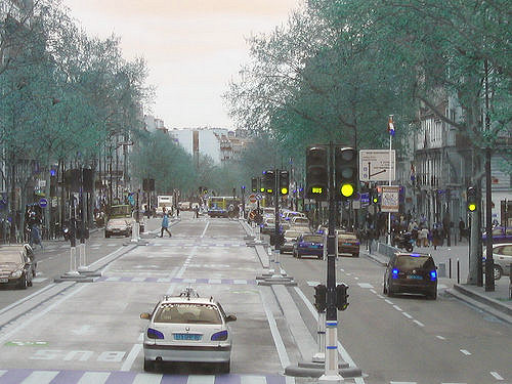

In [18]:
DIR = '/content/Mask_RCNN/images'
file = random.choice(os.listdir(DIR))
file = os.path.join(DIR, file)
print(file)
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = imutils.resize(image, width=512)
cv2_imshow(image) 

Запускаем модель

In [19]:
r = model.detect([image], verbose=1)[0]

Processing 1 images
image                    shape: (384, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



Данная модель способна определить более 80 различных объектов. Соответствующий файл скачивается в формате .json, который нетрудно распарсить средствами питона. Но для данной темы достаточно определить эти типы объектов явным образом.

In [20]:
CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush'] 

Что мы ожидаем увидеть? На выбранном изображении модель найдет все объекты из списка и сегментирует их.

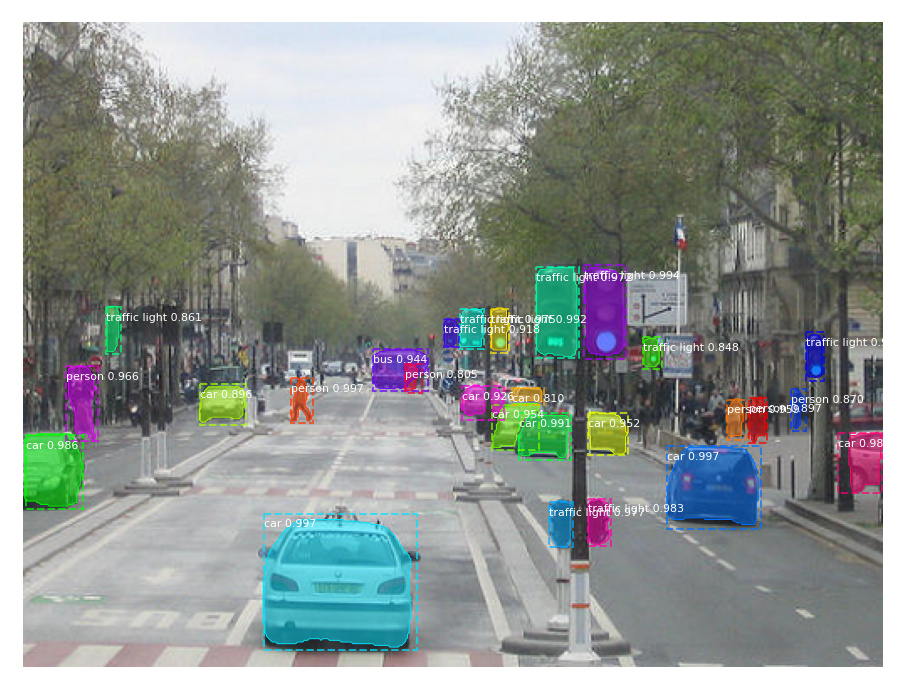

In [21]:
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            CLASS_NAMES, r['scores'])
